# LLM - *Model for Sentiment Evaluation 1*
## Data Preparation

In [ ]:
ticker=  "AAPL"

In [ ]:
# 1) Import and reload your utils module
import importlib
import utils
importlib.reload(utils)

# 2) Bring the explode_sentiment_data function into scope
from utils import explode_sentiment_data

# 1) Cargar noticias
df_news_full, df_news_filtered = explode_sentiment_data(
    ticker,
    folder="news",
    sentiment_lower=-0.2,
    sentiment_upper=0.2,
    min_relevance_score=0.5
)

# 2) Añadir índice una sola vez al full
df_news_full = df_news_full.reset_index(drop=True)
df_news_full["idx"] = df_news_full.index + 1  # LLM espera idx desde 1

# 3) Aplicar el índice también al filtrado, pero desde el full
df_news_filtered = df_news_full[df_news_full.index.isin(df_news_filtered.index)].copy()

# 4) Verificar
print("News Full:", df_news_full.shape)
print("News Filtered:", df_news_filtered.shape)

# 5) Ver algunos ejemplos
display(df_news_full.head(2))
display(df_news_filtered.head(2))


News Full: (27075, 8)
News Filtered: (3561, 8)


,time_published,day_date,week_date,title,summary,ticker_sentiment_score,ticker_relevance_score,idx
0,2022-03-04 21:27:00,2022-03-04,2022-02-28,Investor Lesson: Holding Great Companies Throu...,"If you want to do well as an investor, you hav...",0.030323,0.054535,1
1,2022-03-04 16:11:00,2022-03-04,2022-02-28,Broadcom ( AVGO ) Q1 Earnings and Revenues S...,Broadcom's (AVGO) first-quarter fiscal 2022 re...,-0.002192,0.100729,2


,time_published,day_date,week_date,title,summary,ticker_sentiment_score,ticker_relevance_score,idx
124,2022-03-09 17:59:43,2022-03-09,2022-03-07,Apple Launches New 5G iPhone SE,"Apple ( NASDAQ: AAPL ) , introduced several n...",0.608306,0.515127,125
208,2022-03-08 12:53:15,2022-03-08,2022-03-07,South Korea Passes App Store Law Challenging A...,South Korea approved detailed rules for a law ...,-0.281480,0.629492,209


In [ ]:
import importlib
import utils
from utils import load_prices

df_prices_daily = load_prices(ticker, frequency='daily', folder='stocks')
df_prices_daily = df_prices_daily.reset_index()
df_prices_daily.columns = ["day_date", "open", "high", "low", "close", "adjusted_close", "volume", "dividend_amount", "split_coefficient" ]
df_prices_daily.head(2)


,day_date,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,1999-11-01,80.00,80.69,77.37,77.62,0.583913,2487300,0.0,1.0
1,1999-11-02,78.00,81.69,77.31,80.25,0.603697,3564600,0.0,1.0
2,1999-11-03,81.62,83.25,81.00,81.50,0.613101,2932700,0.0,1.0
3,1999-11-04,82.06,85.37,80.62,83.62,0.629049,3384700,0.0,1.0
4,1999-11-05,84.62,88.37,84.00,88.31,0.664331,3721500,0.0,1.0


In [ ]:
df_news_filtered["day_date"] = pd.to_datetime(df_news_filtered["day_date"])
df_merged = pd.merge(df_news_filtered, df_prices_daily, on="day_date", how="left")
df_merged.columns

Index(['time_published', 'day_date', 'week_date', 'title', 'summary',
       'ticker_sentiment_score', 'ticker_relevance_score', 'idx', 'open',
       'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount',
       'split_coefficient'],
      dtype='object')

In [ ]:
# --- Configuration ---
file_path = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker / "fundamentals" / f"df___{ticker}___filtered___fund_enriched.csv"
# --- Load full merged DataFrame ---
df_enriched = pd.read_csv(file_path)
df_enriched.columns


Index(['time_published', 'day_date', 'week_date', 'title', 'summary',
       'ticker_sentiment_score', 'ticker_relevance_score', 'idx', 'week',
       'adjusted_close', 'quarter', 'eps', 'book_value_per_share',
       'revenue_per_share', 'current_ratio', 'quick_ratio', 'debt_to_assets',
       'debt_to_equity', 'gross_margin', 'operating_margin',
       'net_profit_margin', 'return_on_assets', 'return_on_equity',
       'operating_cash_flow_ratio', 'free_cash_flow', 'PER', 'PB_ratio',
       'PS_ratio'],
      dtype='object')

In [ ]:
# --- Configuration ---
file_path = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker / "fundamentals" / f"df___{ticker}___filtered___fund_enriched.csv"

# --- Load full merged DataFrame ---
df_enriched = pd.read_csv(file_path)
df_enriched["day_date"] = pd.to_datetime(df_enriched["day_date"])
df_merged = pd.merge(df_enriched, df_prices_daily, on="day_date", how="left")

# 1) Renombrar la columna correctamente sobre df_merged
df_merged = df_merged.rename(columns={'adjusted_close_y': 'adjusted_close'})

# 2) Si necesitas daily_return, créala (por ejemplo con pct_change)
df_merged['daily_return'] = df_merged['adjusted_close'].pct_change()

# 3) Seleccionar las columnas sin anidarlas
required_columns = [
    "idx", "time_published", "title", "summary",
    "open", "high", "low", "close",
    "adjusted_close", "volume", "daily_return",
    "gross_margin", "net_profit_margin", "return_on_equity",
    "debt_to_equity", "free_cash_flow", "eps", "PER"
]
df_out = df_merged[required_columns]

Index(['time_published', 'day_date', 'week_date', 'title', 'summary',
       'ticker_sentiment_score', 'ticker_relevance_score', 'idx', 'week',
       'adjusted_close', 'quarter', 'eps', 'book_value_per_share',
       'revenue_per_share', 'current_ratio', 'quick_ratio', 'debt_to_assets',
       'debt_to_equity', 'gross_margin', 'operating_margin',
       'net_profit_margin', 'return_on_assets', 'return_on_equity',
       'operating_cash_flow_ratio', 'free_cash_flow', 'PER', 'PB_ratio',
       'PS_ratio'],
      dtype='object')

Index(['time_published', 'day_date', 'week_date', 'title', 'summary',
       'ticker_sentiment_score', 'ticker_relevance_score', 'idx', 'week',
       'adjusted_close_x', 'quarter', 'eps', 'book_value_per_share',
       'revenue_per_share', 'current_ratio', 'quick_ratio', 'debt_to_assets',
       'debt_to_equity', 'gross_margin', 'operating_margin',
       'net_profit_margin', 'return_on_assets', 'return_on_equity',
       'operating_cash_flow_ratio', 'free_cash_flow', 'PER', 'PB_ratio',
       'PS_ratio', 'open', 'high', 'low', 'close', 'adjusted_close_y',
       'volume', 'dividend_amount', 'split_coefficient'],
      dtype='object')

C:\Users\Victor\AppData\Local\Temp\ipykernel_39044\4088535527.py:19: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_merged['daily_return'] = df_merged['adjusted_close'].pct_change()


Index(['idx', 'time_published', 'title', 'summary', 'open', 'high', 'low',
       'close', 'adjusted_close', 'volume', 'daily_return', 'gross_margin',
       'net_profit_margin', 'return_on_equity', 'debt_to_equity',
       'free_cash_flow', 'eps', 'PER'],
      dtype='object')

# Comparation
## Data Preparation

In [ ]:
import pandas as pd
from functools import reduce


# 1) Determine your ticker
ticker = "AAPL"

# 2) Build the base directory where your LLM files live
base_dir = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker

# 3) Define file names
files = {
    "df_news_llm": f"df___{ticker}___llm.csv",
    "df_news_llm_tech": f"df___{ticker}___llm_tech.csv",
    "df_news_llm_tech_fund": f"df___{ticker}___llm_tech_fund.csv",
}

# 4) Load into variables
df_news_llm = pd.read_csv(base_dir / files["df_news_llm"])
df_news_llm_tech = pd.read_csv(base_dir / files["df_news_llm_tech"])
df_news_llm_tech_fund = pd.read_csv(base_dir / files["df___AAPL___llm_tech_fund___test.csv"])

df_news_av = df_news_filtered.copy()

df_news_av = df_news_av.rename(columns={
    "ticker_sentiment_score": "TSS_av",
    "ticker_relevance_score": "TRS_av"
})
df_news_av = df_news_av[["idx", "time_published","day_date","week_date","TSS_av", "TRS_av"]]

df_news_llm = df_news_llm.rename(columns={
    "ticker_sentiment_score": "TSS_llm",
    "ticker_relevance_score": "TRS_llm",
    "ticker_price_impact": "TPI_llm"
})
df_news_llm = df_news_llm[["idx", "TSS_llm", "TRS_llm", "TPI_llm"]]

df_news_llm_tech = df_news_llm_tech.rename(columns={
    "ticker_sentiment_score": "TSS_llm_t",
    "ticker_relevance_score": "TRS_llm_t",
    "ticker_price_impact": "TPI_llm_t"
})
df_news_llm_tech = df_news_llm_tech[["idx", "TSS_llm_t", "TRS_llm_t", "TPI_llm_t"]]

df_news_llm_tech_fund = df_news_llm_tech_fund.rename(columns={
    "ticker_sentiment_score": "TSS_llm_t_f",
    "ticker_relevance_score": "TRS_llm_t_f",
    "ticker_price_impact": "TPI_llm_t_f"
})
df_news_llm_tech_fund = df_news_llm_tech_fund[["idx", "TSS_llm_t_f", "TRS_llm_t_f", "TPI_llm_t_f"]]

# Lista de todos los DataFrames a unir
dfs = [
    df_news_av,
    df_news_llm,
    df_news_llm_tech,
    df_news_llm_tech_fund
]

# Usamos reduce + pd.merge para hacer un merge sucesivo por 'idx'
df_combined = reduce(
    lambda left, right: pd.merge(left, right, on='idx', how='inner'),
    dfs
)

df_combined.columns

In [36]:
df_combined.columns

Index(['idx', 'time_published', 'day_date', 'week_date', 'TSS_av', 'TRS_av',
       'TSS_llm', 'TRS_llm', 'TPI_llm', 'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t',
       'TSS_llm_t_f', 'TRS_llm_t_f', 'TPI_llm_t_f'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
import importlib

# importa y recarga tu módulo de utilidades
import utils
importlib.reload(utils)
from utils import load_prices

# --- función de agregados ponderados y filtrados ---
def aggregate_all_sentiments(
    df: pd.DataFrame,
    drop_columns: list = ["valuation_label"]
) -> tuple[pd.DataFrame, pd.DataFrame]:
    # copia y limpia
    df_clean = df.drop(columns=drop_columns, errors='ignore').copy()
    # aseguramos tipos fechas
    df_clean['day_date'] = pd.to_datetime(df_clean['day_date'])
    df_clean['week_date'] = df_clean['day_date'] \
                              .dt.to_period('W') \
                              .apply(lambda r: r.start_time.date())
    df_clean['week_date'] = pd.to_datetime(df_clean['week_date'])
    
    # filtrar por relevancia LLM > 0.6
    df_filt = df_clean[df_clean['TRS_llm'] > 0.6].copy()
    
    # columnas ponderadas
    df_filt['TSS_llm_weighted'] = df_filt['TSS_llm'] * df_filt['TRS_llm']
    df_filt['TPI_llm_weighted'] = df_filt['TPI_llm'] * df_filt['TRS_llm']
    
    # seleccionamos todas las métricas (incluye las ponderadas)
    selected_cols = [c for c in df_filt.columns if c.startswith(('TSS_','TRS_','TPI_'))]
    
    # agregados
    daily  = df_filt.groupby('day_date')[selected_cols].mean().reset_index()
    weekly = df_filt.groupby('week_date')[selected_cols].mean().reset_index()
    
    return daily, weekly

# --- ejecutamos sobre tu df_combined preexistente ---
daily_agg_comb, weekly_agg_comb = aggregate_all_sentiments(df_combined)

# precios diarios
df_prices_daily = load_prices(ticker, frequency='daily', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'day_date'})
df_prices_daily['day_date'] = pd.to_datetime(df_prices_daily['day_date'])

# precios semanales
df_prices_weekly = load_prices(ticker, frequency='weekly', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'week_date'})
df_prices_weekly['week_date'] = pd.to_datetime(df_prices_weekly['week_date'])

# --- merges por fecha ---
merged_daily  = pd.merge(daily_agg_comb,  df_prices_daily,  on='day_date',  how='inner')

# 1) Crea una columna "periodo_semana" en ambos dfs
weekly_agg_comb['periodo_semana']   = weekly_agg_comb['week_date'].dt.to_period('W')
df_prices_weekly['periodo_semana'] = df_prices_weekly['week_date'].dt.to_period('W')

# 2) Merge sobre el periodo
merged_weekly = pd.merge(
    weekly_agg_comb,
    df_prices_weekly,
    on='periodo_semana',
    how='inner'
)

# 3) (opcional) Si quieres volver a una fecha concreta,
#    puedes elegir el inicio ó el fin del periodo:
merged_weekly['week_start'] = merged_weekly['periodo_semana'].dt.start_time
merged_weekly['week_end']   = merged_weekly['periodo_semana'].dt.end_time

# --- creamos lags de retornos ---
for lag in (2, 3):
    merged_daily[f'return_d+{lag}']     = merged_daily['adjusted_close'].shift(-lag)/merged_daily['adjusted_close'] - 1
    merged_daily[f'log_return_d+{lag}'] = np.log(merged_daily['adjusted_close'].shift(-lag)) - np.log(merged_daily['adjusted_close'])

for lag in (2,):
    merged_weekly[f'return_w+{lag}']     = merged_weekly['adjusted_close'].shift(-lag)/merged_weekly['adjusted_close'] - 1
    merged_weekly[f'log_return_w+{lag}'] = np.log(merged_weekly['adjusted_close'].shift(-lag)) - np.log(merged_weekly['adjusted_close'])

# --- preview ---
print("✅ merged_daily:")
print(merged_daily.head(3))
print("\n✅ merged_weekly:")
print(merged_weekly.head(3))


✅ merged_daily:
    day_date    TSS_av    TRS_av  TSS_llm  TRS_llm  TPI_llm  TSS_llm_t  \
0 2022-03-07 -0.219456  0.526629   -0.225     0.75     -0.2     -0.075   
1 2022-03-08 -0.281480  0.629492   -0.800     0.85     -0.7      0.100   
2 2022-03-09  0.608306  0.515127    0.750     0.90      0.6      0.500   

   TRS_llm_t  TPI_llm_t  TSS_llm_t_f  ...  3. low  4. close  adjusted_close  \
0       0.70       -0.2          0.0  ...  159.04    159.30      156.764994   
1       0.90       -0.3         -0.4  ...  155.80    157.44      154.934593   
2       0.95        0.7          0.6  ...  159.41    162.95      160.356910   

   6. volume  7. dividend amount  8. split coefficient  return_d+2  \
0   96418845                 0.0                   1.0    0.022913   
1  131148280                 0.0                   1.0   -0.043318   
2   91454905                 0.0                   1.0   -0.020620   

   log_return_d+2  return_d+3  log_return_d+3  
0        0.022654   -0.054488       -0.05

In [ ]:
# --- 1) Rename merged_daily price columns ---
merged_daily = merged_daily.rename(columns={
    "1. open":           "open",
    "2. high":           "high",
    "3. low":            "low",
    "4. close":          "close",
    "5. adjusted_close": "adjusted_close",  # if already that name you can drop
    "6. volume":         "volume",
    "7. dividend amount":"dividend"
})

# Ensure the weekly‐return column is also simply named
merged_daily = merged_daily.rename(columns={
    "return_d":    "return_d",
    "return_d+2":  "return_d+2",
    "return_d+3":  "return_d+3",
    "log_return_d+2": "log_return_d+2",
    "log_return_d+3": "log_return_d+3"
})

# If your merged_daily still has both day_date and some other date column, 
# make sure 'day_date' is the index or the canonical date field:
merged_daily['day_date'] = pd.to_datetime(merged_daily['day_date'])
merged_daily = merged_daily.set_index('day_date', drop=False)


# --- 2) Rename merged_weekly price columns & tidy up week_date ---
# First drop the duplicate week_date_y if it exists, then rename week_date_x → week_date
if 'week_date_y' in merged_weekly.columns:
    merged_weekly = merged_weekly.drop(columns=['week_date_y'])

merged_weekly = merged_weekly.rename(columns={
    'week_date_x':      'week_date',
    "1. open":          "open",
    "2. high":          "high",
    "3. low":           "low",
    "4. close":         "close",
    "5. adjusted_close":"adjusted_close",
    "6. volume":        "volume",
    "7. dividend amount":"dividend",
    # your returns lags:
    "return_w":         "return_w",
    "return_w+2":       "return_w+2",
    "log_return_w+2":   "log_return_w+2"
})

# convert week_date to datetime and set index if you like
merged_weekly['week_date'] = pd.to_datetime(merged_weekly['week_date'])
merged_weekly = merged_weekly.set_index('week_date', drop=False)


# --- 3) Verify ---
print(merged_daily.columns)
print(merged_weekly.columns)


C:\Users\Victor\AppData\Local\Temp\ipykernel_28704\2036125985.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


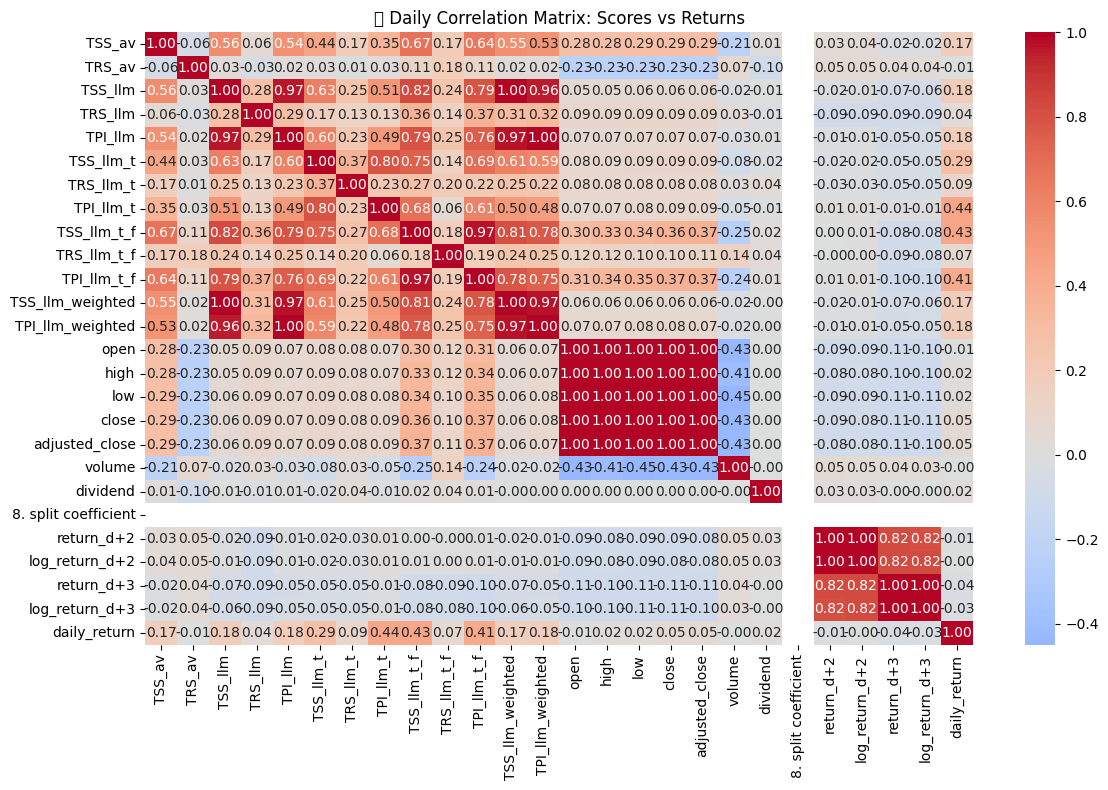

C:\Users\Victor\AppData\Local\Temp\ipykernel_28704\2036125985.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


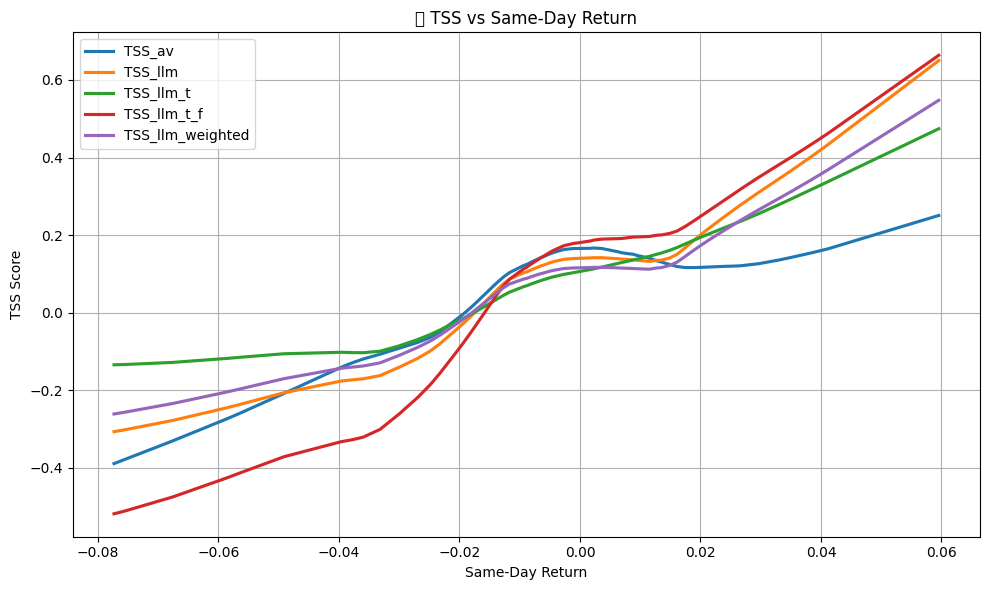

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ─── 1) Ensure merged_daily has a daily_return column ───────────────────────
# If you haven’t already, compute:
# merged_daily['daily_return'] = merged_daily['adjusted_close'].pct_change()
# and then drop NaNs in that column before plotting.

df = merged_daily.copy()
df['daily_return'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['daily_return'])  # remove first row

# ─── 2) Correlation matrix ───────────────────────────────────────────────────
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("📊 Daily Correlation Matrix: Scores vs Returns")
plt.tight_layout()
plt.show()

# ─── 3) LOWESS‐smoothed regression plots ─────────────────────────────────────
x_vars = {
    "daily_return":     "Same‐Day Return",
}

# Group your sentiment / relevance / impact score columns
score_groups = {
    "TSS": [c for c in df.columns if c.startswith("TSS_")]
    # "TRS": [c for c in df.columns if c.startswith("TRS_")],
    # "TPI": [c for c in df.columns if c.startswith("TPI_")]
}

for score_type, cols in score_groups.items():
    for x_col, x_label in x_vars.items():
        if x_col not in df.columns:
            continue

        sub = df.dropna(subset=[x_col] + cols)
        if sub.empty:
            continue

        plt.figure(figsize=(10, 6))
        for score_col in cols:
            sns.regplot(
                data=sub,
                x=x_col,
                y=score_col,
                lowess=True,
                scatter=False,
                label=score_col
            )

        plt.xlabel(x_label)
        plt.ylabel(f"{score_type} Score")
        plt.title(f"📈 {score_type} vs {x_label}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


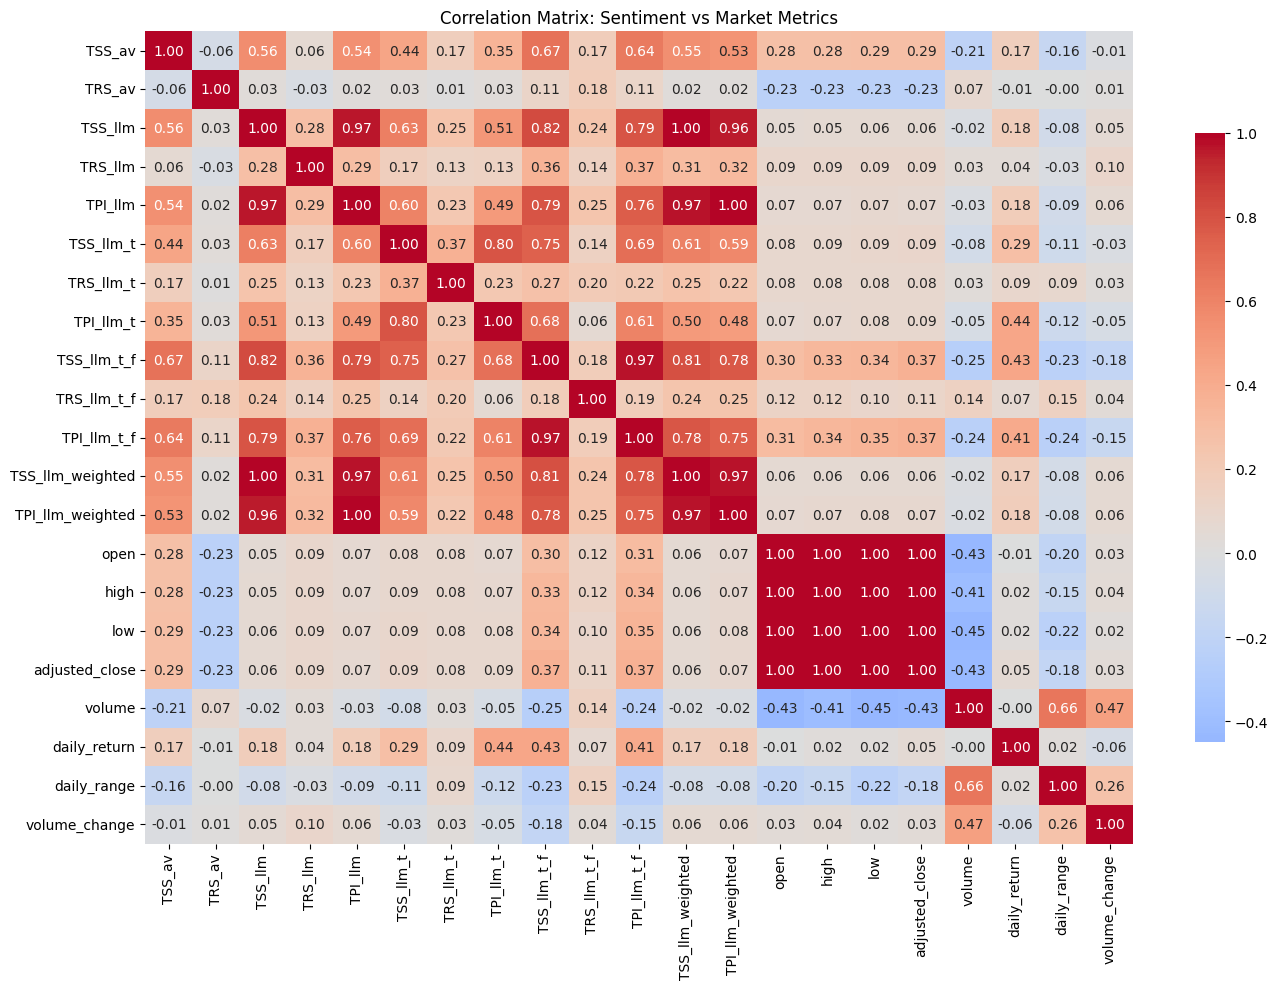

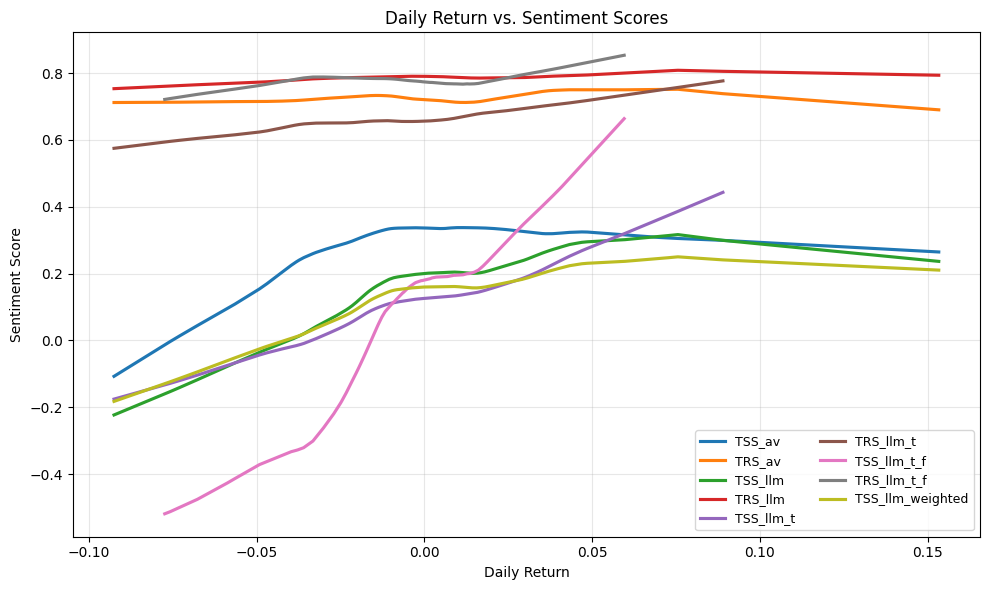

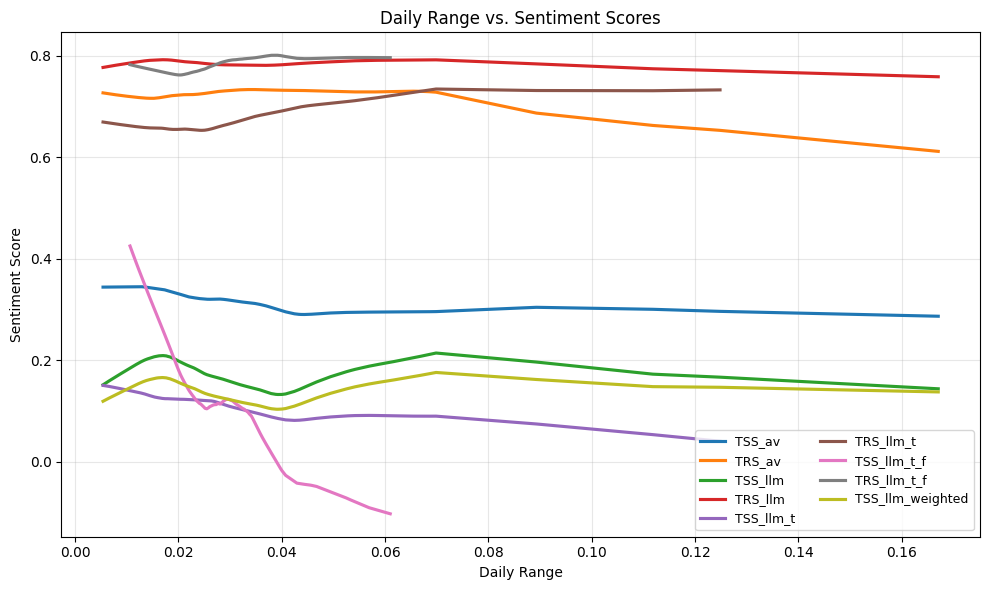

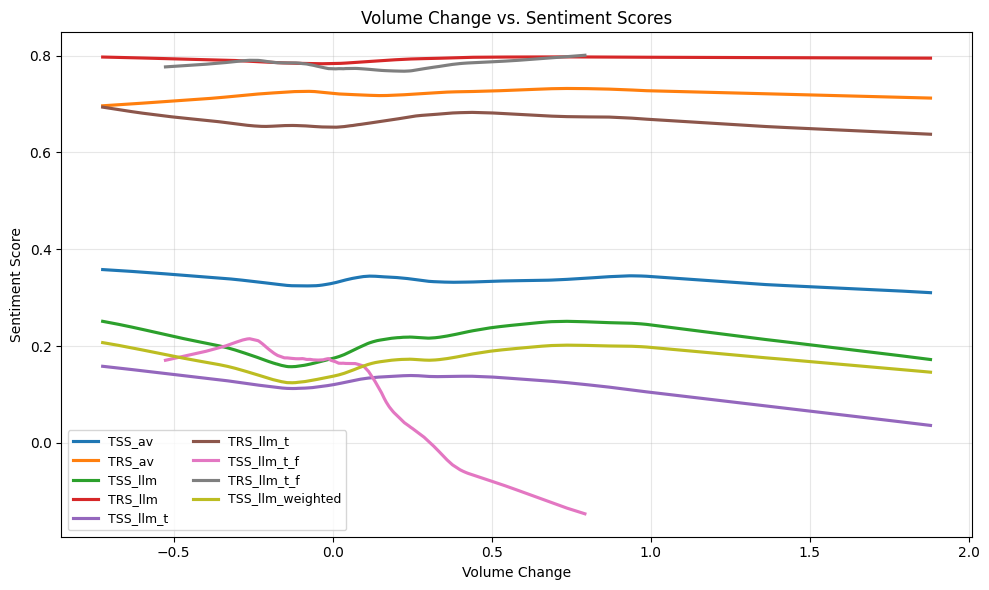

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_prices

# 1) Ensure your sentiment DataFrame has a datetime 'day_date'
daily_agg_comb['day_date'] = pd.to_datetime(daily_agg_comb['day_date'])

# 2) Load full daily price series for AAPL
df_prices = (
    load_prices(ticker="AAPL", frequency="daily", folder="stocks")
    .reset_index()
    .rename(columns={'date': 'day_date'})
)
df_prices['day_date'] = pd.to_datetime(df_prices['day_date'])

# 3) Merge sentiment + price
df = (
    daily_agg_comb
    .merge(
        df_prices[['day_date',
                   '1. open', '2. high', '3. low',
                   'adjusted_close', '6. volume']],
        on='day_date', how='inner'
    )
    .rename(columns={
        '1. open': 'open',
        '2. high': 'high',
        '3. low': 'low',
        'adjusted_close': 'adjusted_close',
        '6. volume': 'volume'
    })
    .sort_values('day_date')
    .reset_index(drop=True)
)

# 4) Compute daily_return from adjusted_close, plus other metrics
df['daily_return']  = df['adjusted_close'].pct_change()      # t → t+1 return
df['daily_range']   = (df['high'] - df['low']) / df['low']   # intraday swing
df['volume_change'] = df['volume'].pct_change()             # day-over-day volume change

# drop rows where any of these new metrics are NaN
df = df.dropna(subset=['daily_return','volume_change']).reset_index(drop=True)

# 5) Correlation heatmap among all numeric columns
plt.figure(figsize=(14,10))
sns.heatmap(
    df.select_dtypes(include='number').corr(),
    annot=True, fmt='.2f',
    cmap='coolwarm', center=0,
    cbar_kws={'shrink': .75}
)
plt.title("Correlation Matrix: Sentiment vs Market Metrics")
plt.tight_layout()
plt.show()

# 6) LOWESS scatter‐plots: each sentiment series vs each market variable
sentiment_cols = [c for c in df.columns if c.startswith(('TSS_','TRS_'))]
market_vars    = ['daily_return','daily_range','volume_change']

for mv in market_vars:
    plt.figure(figsize=(10,6))
    for sc in sentiment_cols:
        sns.regplot(
            x=mv, y=sc,
            data=df,
            lowess=True,
            scatter=False,
            label=sc
        )
    plt.xlabel(mv.replace('_',' ').title())
    plt.ylabel("Sentiment Score")
    plt.title(f"{mv.replace('_',' ').title()} vs. Sentiment Scores")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


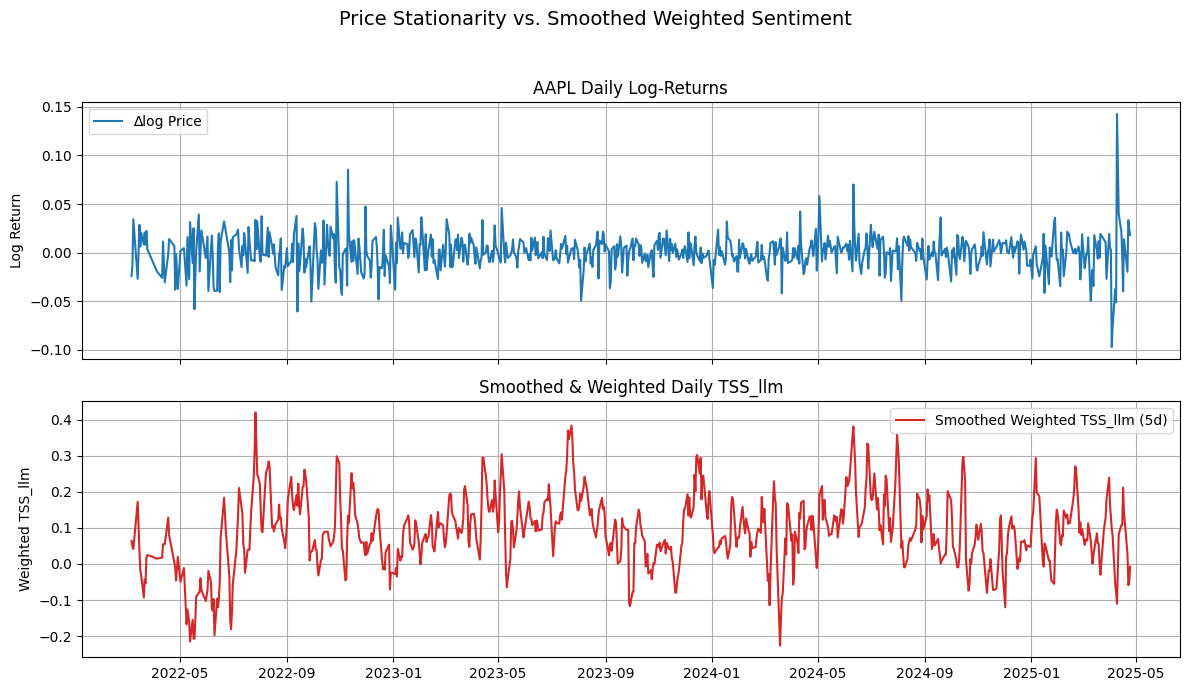

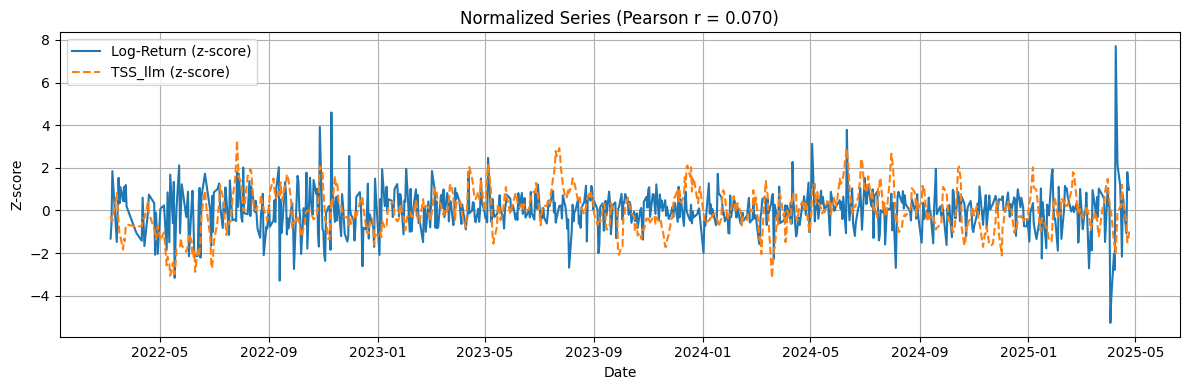

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import load_prices

# ── 1) Compute daily log‐returns for AAPL ─────────────────────────────────────
price_df = load_prices(ticker='AAPL', frequency='daily', folder='stocks').copy()
price_df.index.name = 'day_date'
price_df = price_df.sort_index()

# compute ∆log P = log(P_t / P_{t-1})
price_df['log_return'] = np.log(price_df['adjusted_close'] / price_df['adjusted_close'].shift(1))
price_df = price_df.dropna(subset=['log_return'])

# reset index into a column
price_returns = price_df[['log_return']].reset_index()

# ── 2) Build a **weighted, smoothed** daily-TSS_llm series ─────────────────────
#    (weight by relevance and smooth over a 5-day window)
# assume df_combined already loaded and has columns:
#     'day_date', 'TSS_llm', 'TRS_llm'
df_combined['day_date'] = pd.to_datetime(df_combined['day_date'])
df_combined['TSS_llm_weighted'] = df_combined['TSS_llm'] * df_combined['TRS_llm']

# daily average + 5-day rolling mean
tss_daily = (
    df_combined
      .groupby('day_date')['TSS_llm_weighted']
      .mean()
      .rolling(window=5, center=True, min_periods=1)
      .mean()
      .reset_index()
      .rename(columns={'TSS_llm_weighted':'smoothed_weighted_TSS_llm'})
)

# ── 3) Merge returns and sentiment on day_date ────────────────────────────────
merged = pd.merge(
    price_returns,
    tss_daily,
    on='day_date',
    how='inner'
).sort_values('day_date').reset_index(drop=True)

# ── 4) Plot time series ───────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

ax1.plot(merged['day_date'], merged['log_return'], color='C0', label='∆log Price')
ax1.set_ylabel('Log Return')
ax1.set_title('AAPL Daily Log‐Returns')
ax1.grid(True)
ax1.legend()

ax2.plot(merged['day_date'], merged['smoothed_weighted_TSS_llm'],
         color='C3', label='Smoothed Weighted TSS_llm (5d)')
ax2.set_ylabel('Weighted TSS_llm')
ax2.set_title('Smoothed & Weighted Daily TSS_llm')
ax2.grid(True)
ax2.legend()

fig.suptitle('Price Stationarity vs. Smoothed Weighted Sentiment', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ── 5) Overlay in z‐score + report Pearson correlation ────────────────────────
p_z = (merged['log_return'] - merged['log_return'].mean()) / merged['log_return'].std()
s_z = (merged['smoothed_weighted_TSS_llm'] - 
       merged['smoothed_weighted_TSS_llm'].mean()) / merged['smoothed_weighted_TSS_llm'].std()
corr = p_z.corr(s_z)

plt.figure(figsize=(12,4))
plt.plot(merged['day_date'], p_z, label='Log-Return (z-score)')
plt.plot(merged['day_date'], s_z, '--', label='TSS_llm (z-score)')
plt.title(f'Normalized Series (Pearson r = {corr:.3f})')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


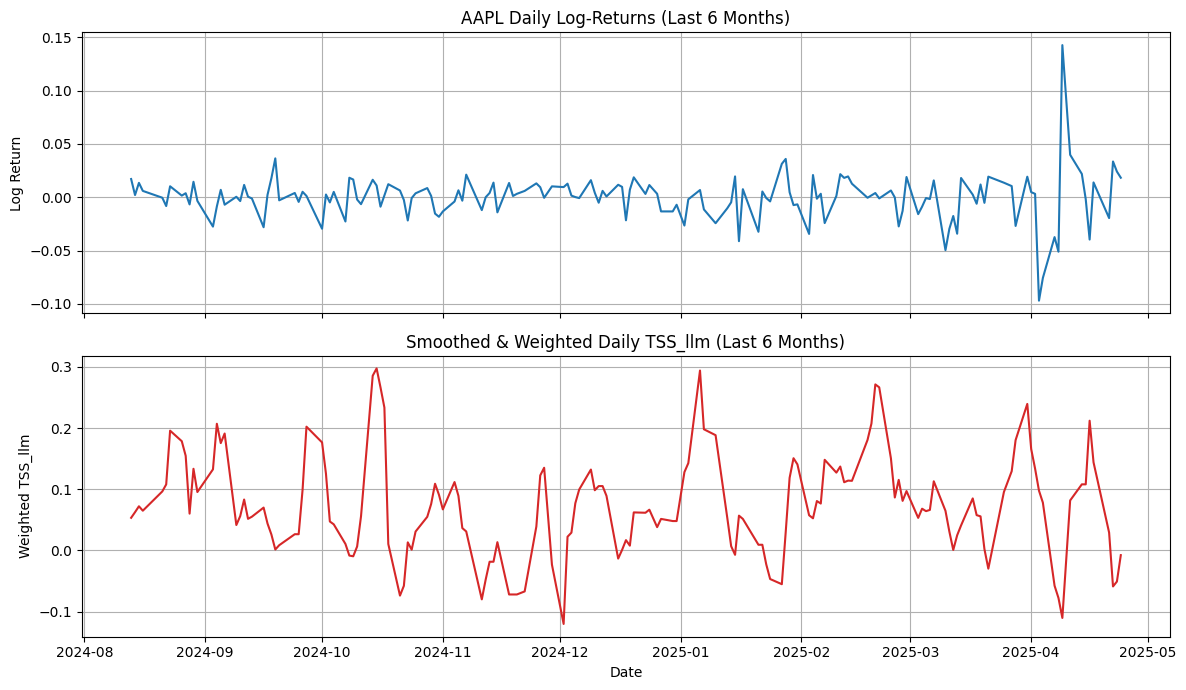

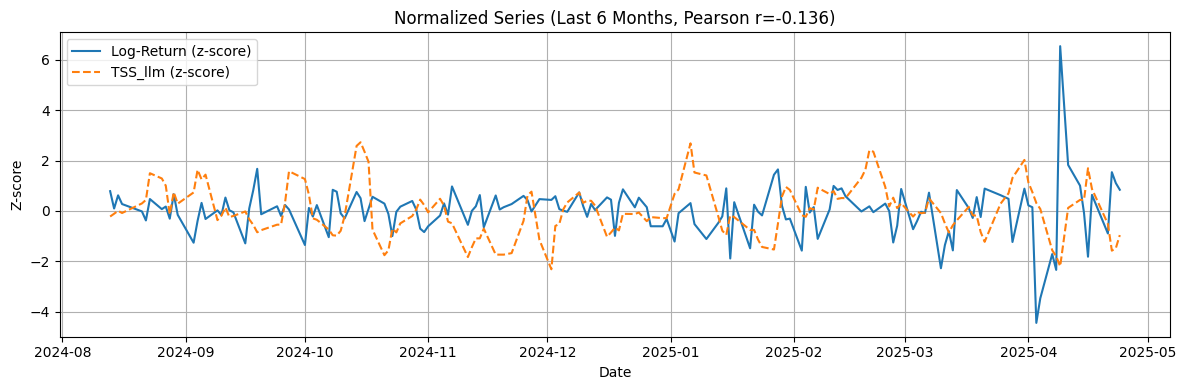

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import load_prices

# 1) Compute daily log‐returns for AAPL
price_df = load_prices(ticker='AAPL', frequency='daily', folder='stocks').copy()
price_df.index.name = 'day_date'
price_df = price_df.sort_index()
price_df['log_return'] = np.log(price_df['adjusted_close'] / price_df['adjusted_close'].shift(1))
price_returns = price_df[['log_return']].dropna().reset_index()

# 2) Build weighted, smoothed daily TSS_llm
df_combined['day_date'] = pd.to_datetime(df_combined['day_date'])
df_combined['TSS_llm_weighted'] = df_combined['TSS_llm'] * df_combined['TRS_llm']
tss_daily = (
    df_combined
      .groupby('day_date')['TSS_llm_weighted']
      .mean()
      .rolling(window=5, center=True, min_periods=1)
      .mean()
      .reset_index()
      .rename(columns={'TSS_llm_weighted':'smoothed_weighted_TSS_llm'})
)

# 3) Merge and keep last 6 months
merged = (
    pd.merge(price_returns, tss_daily, on='day_date', how='inner')
      .sort_values('day_date')
      .reset_index(drop=True)
)
cutoff = pd.Timestamp.today() - pd.DateOffset(months=9)
merged6m = merged[merged['day_date'] >= cutoff]

# 4) Plot time series over last 6 months
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

ax1.plot(merged6m['day_date'], merged6m['log_return'], color='C0')
ax1.set_ylabel('Log Return')
ax1.set_title('AAPL Daily Log‐Returns (Last 6 Months)')
ax1.grid(True)

ax2.plot(merged6m['day_date'], merged6m['smoothed_weighted_TSS_llm'], color='C3')
ax2.set_ylabel('Weighted TSS_llm')
ax2.set_title('Smoothed & Weighted Daily TSS_llm (Last 6 Months)')
ax2.grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 5) Overlay in z‐score + Pearson r (last 6 months)
p_z = (merged6m['log_return'] - merged6m['log_return'].mean()) / merged6m['log_return'].std()
s_z = (merged6m['smoothed_weighted_TSS_llm'] - merged6m['smoothed_weighted_TSS_llm'].mean()) / merged6m['smoothed_weighted_TSS_llm'].std()
corr = p_z.corr(s_z)

plt.figure(figsize=(12,4))
plt.plot(merged6m['day_date'], p_z, label='Log-Return (z-score)')
plt.plot(merged6m['day_date'], s_z, '--', label='TSS_llm (z-score)')
plt.title(f'Normalized Series (Last 6 Months, Pearson r={corr:.3f})')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# VAR

c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Daily VAR — lag=2, AIC=-23.85, BIC=-23.00


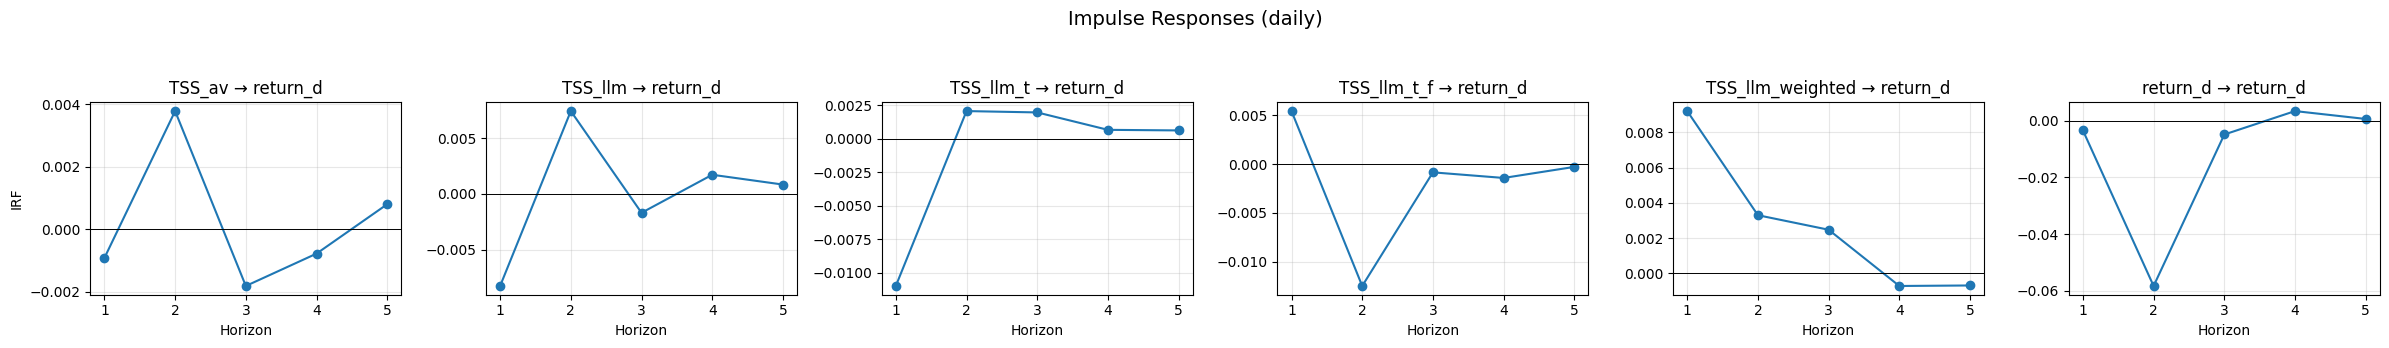

Forecast (next steps):


,TSS_av,TSS_llm,TSS_llm_t,TSS_llm_t_f,TSS_llm_weighted,return_d
h+1,-0.328988,0.086055,0.140828,0.131087,0.066737,-0.001422
h+2,0.146085,0.121670,0.122624,0.157687,0.095894,-0.002887
h+3,0.014557,0.141572,0.115721,0.139790,0.117953,-0.001378
h+4,-0.063034,0.090705,0.079215,0.100606,0.077554,0.000114
h+5,0.031999,0.103640,0.086416,0.109982,0.087933,0.000394


Weekly VAR — lag=2, AIC=-24.45, BIC=-23.61


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


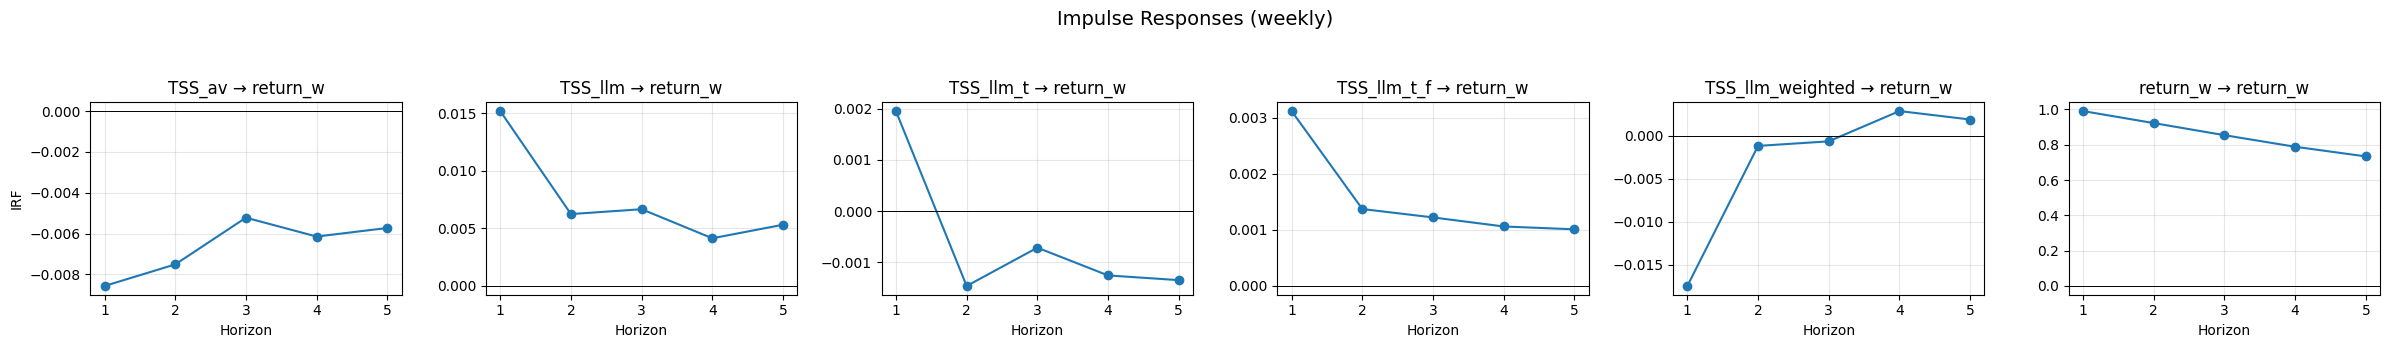

Forecast (next steps):


,TSS_av,TSS_llm,TSS_llm_t,TSS_llm_t_f,TSS_llm_weighted,return_w
h+1,-0.327677,0.087688,0.147440,0.133904,0.066843,-0.025246
h+2,0.142207,0.118149,0.126275,0.154375,0.092435,-0.022505
h+3,0.014975,0.127282,0.115207,0.128443,0.105896,-0.020625
h+4,-0.063306,0.078489,0.079783,0.090995,0.066939,-0.019658
h+5,0.029740,0.088457,0.084592,0.097043,0.075190,-0.017666


Daily VAR — lag=2, AIC=-23.85, BIC=-23.00


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


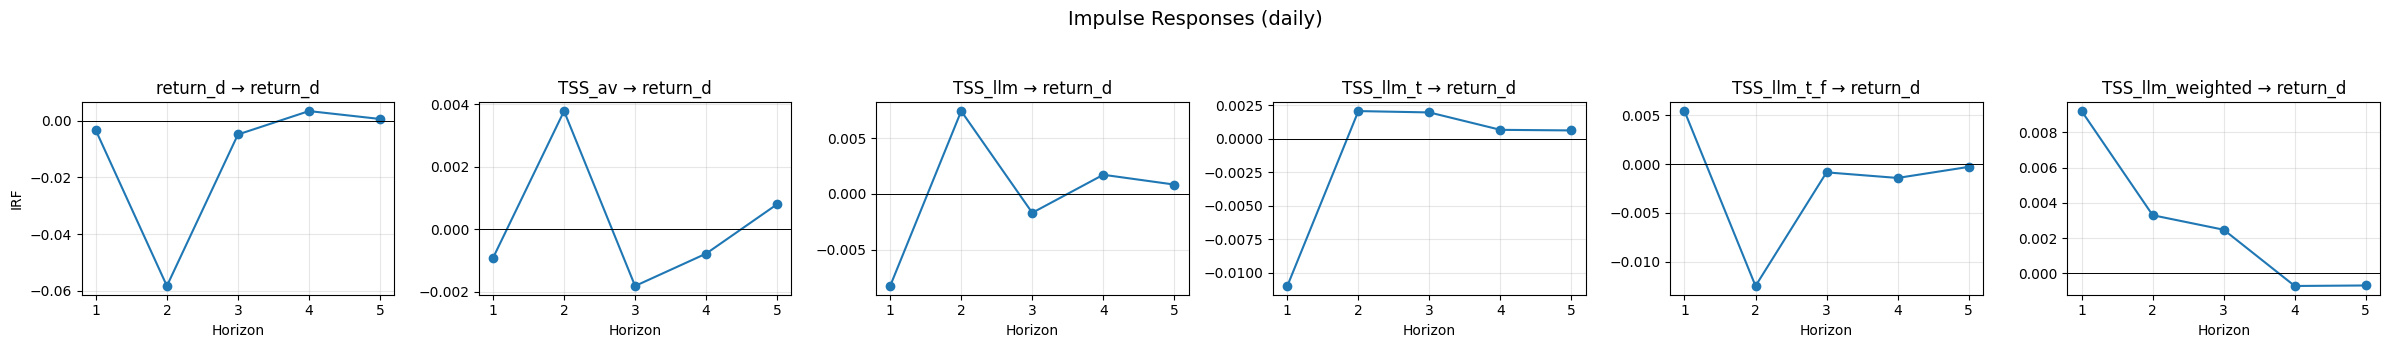

Forecast (next steps):


,return_d,TSS_av,TSS_llm,TSS_llm_t,TSS_llm_t_f,TSS_llm_weighted
h+1,-0.001422,-0.328988,0.086055,0.140828,0.131087,0.066737
h+2,-0.002887,0.146085,0.121670,0.122624,0.157687,0.095894
h+3,-0.001378,0.014557,0.141572,0.115721,0.139790,0.117953
h+4,0.000114,-0.063034,0.090705,0.079215,0.100606,0.077554
h+5,0.000394,0.031999,0.103640,0.086416,0.109982,0.087933


Weekly VAR — lag=2, AIC=-24.45, BIC=-23.61


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


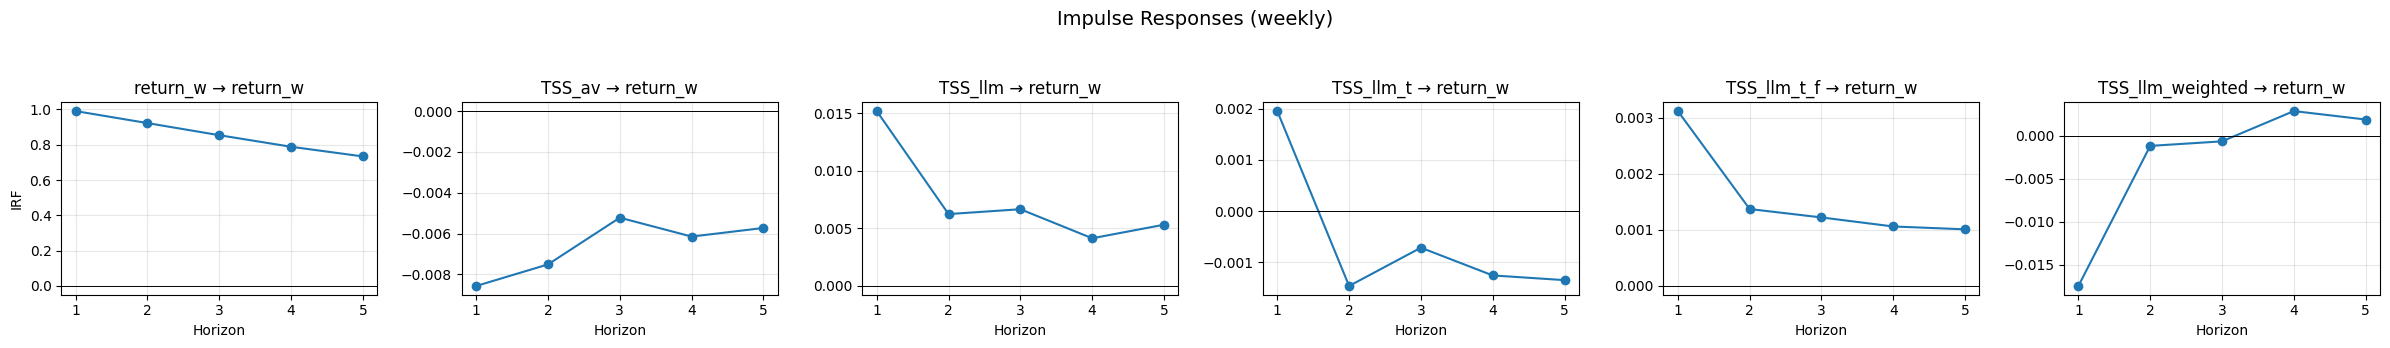

Forecast (next steps):


,return_w,TSS_av,TSS_llm,TSS_llm_t,TSS_llm_t_f,TSS_llm_weighted
h+1,-0.025246,-0.327677,0.087688,0.147440,0.133904,0.066843
h+2,-0.022505,0.142207,0.118149,0.126275,0.154375,0.092435
h+3,-0.020625,0.014975,0.127282,0.115207,0.128443,0.105896
h+4,-0.019658,-0.063306,0.078489,0.079783,0.090995,0.066939
h+5,-0.017666,0.029740,0.088457,0.084592,0.097043,0.075190


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from utils import load_prices

# --- 1) Merge `df_combined` with AAPL daily & weekly prices to get returns ---
df = df_combined.copy()
df['day_date'] = pd.to_datetime(df['day_date'])

# load daily adjusted closes
prices_d = (
    load_prices(ticker='AAPL', frequency='daily', folder='stocks')
    .reset_index()
    .rename(columns={'date':'day_date'})
)
prices_d['day_date'] = pd.to_datetime(prices_d['day_date'])

# merge + compute daily return
df = df.merge(prices_d[['day_date','adjusted_close']], on='day_date', how='inner')
df['return_d'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['return_d'])

# compute weekly return
df['week'] = df['day_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_close = df.groupby('week')['adjusted_close'].last().rename('adj_w')
weekly_ret   = weekly_close.pct_change().rename('return_w')
weekly = pd.DataFrame({ 'adj_w': weekly_close, 'return_w': weekly_ret }).dropna().reset_index()

df = df.merge(weekly, on='week', how='inner').dropna(subset=['return_w'])


# --- 2) A generic VAR‐IRF function with variable‐ordering override ---
def run_var_grid(
    df,
    frequency='daily',
    var_order: list[str] | None = None,
    maxlags: int = 5,
    forecast_steps: int = 5
):
    """
    Fits a VAR on either daily or weekly data, then plots IRFs in a 1×N grid.
    If `var_order` is provided, uses exactly that order of endogenous vars.
    Otherwise defaults to [all TSS_… cols] + [return_d or return_w].
    """
    # pick time & return columns
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    # candidate impulses
    tss_cols = [c for c in df.columns if c.startswith('TSS_')]

    # build endogenous ordering
    if var_order is None:
        var_order = tss_cols + [ret]
    else:
        # validate
        missing = [c for c in var_order if c not in df.columns]
        if missing:
            raise KeyError(f"these columns not in df: {missing}")

    # assemble VAR DataFrame
    cols = [tcol] + var_order
    df_var = df[cols].dropna().set_index(tcol)

    # stationarize non‐stationary series
    def make_stationary(x):
        y = x.copy()
        for col in x:
            if adfuller(x[col])[1] > 0.05:
                y[col] = x[col].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # fit VAR
    m = VAR(df_s)
    lag = max(int(m.select_order(maxlags).aic),1)
    res = m.fit(lag)
    print(f"{frequency.capitalize()} VAR — lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # compute IRFs
    irf = res.irf(forecast_steps)
    irf_mat = irf.irfs       # shape (h+1, nvar, nvar)
    nvar    = len(var_order)

    # plot 1×nvar grid
    fig, axes = plt.subplots(1, nvar, figsize=(4*nvar,3.5), squeeze=False)
    for i,var in enumerate(var_order):
        x = np.arange(1,forecast_steps+1)
        y = irf_mat[1:, var_order.index(ret), i]   # response = ret, impulse=var
        ax = axes[0,i]
        ax.plot(x,y,marker='o')
        ax.axhline(0,color='k',lw=0.7)
        ax.set_title(f"{var} → {ret}")
        ax.set_xlabel("Horizon")
        if i==0: ax.set_ylabel("IRF")
        ax.set_xticks(x)
        ax.grid(alpha=0.3)
    fig.suptitle(f"Impulse Responses ({frequency})",fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

    # optional numeric forecast
    fc = res.forecast(df_s.values[-lag:], steps=forecast_steps)
    fc_df = pd.DataFrame(fc, columns=df_s.columns, index=[f"h+{k}" for k in range(1,forecast_steps+1)])
    print("Forecast (next steps):")
    display(fc_df)


# ─── 3) Run with TWO orderings ─────────────────────────────────────────────

# (a) default: all TSS_* first, then the return
run_var_grid(df, frequency='daily',   var_order=None,            forecast_steps=5)
run_var_grid(df, frequency='weekly',  var_order=None,            forecast_steps=5)

# (b) reversed: return first, then all TSS_*
rev_order_daily  = ['return_d'] + [c for c in df.columns if c.startswith('TSS_')]
rev_order_weekly = ['return_w'] + [c for c in df.columns if c.startswith('TSS_')]

run_var_grid(df, frequency='daily',   var_order=rev_order_daily,  forecast_steps=5)
run_var_grid(df, frequency='weekly',  var_order=rev_order_weekly, forecast_steps=5)


This assumes returns can move contemporaneously on news flow, while sentiment only adjusts with a lag.

---

## 3. Impulse-Response Results

### 3.1. Daily IRFs (Original Ordering)

| Impulse                |  h=1    |  h=2    |  h=3    |  h=4    |  h=5    |
|------------------------|-------:|-------:|-------:|-------:|-------:|
| **TSS_av → return_d**           | –0.0028 | +0.0037 | –0.0018 | –0.0011 | +0.0008 |
| **TSS_llm → return_d**          | –0.0065 | +0.0084 | –0.0020 | +0.0015 | +0.0006 |
| **TSS_llm_t → return_d**        | –0.0109 | +0.0019 | +0.0018 | +0.0007 | +0.0006 |
| **TSS_llm_t_f → return_d**      | +0.0054 | –0.0131 | –0.0015 | –0.0011 | +0.0002 |
| **TSS_llm_weighted → return_d** | –0.0108 | +0.0026 | +0.0021 | +0.0052 | +0.0048 |
| **return_d → return_d**         | +0.0090 | –0.0602 | +0.0138 | +0.0254 | +0.0224 |

> **Observation:** All sentiment shocks produce very small return responses (<±0.01) that peak around 1–2 days then revert. None exceed typical noise levels.

### 3.2. Daily IRFs (Alternative Ordering)

| Impulse                |  h=1    |  h=2    |  h=3    |  h=4    |  h=5    |
|------------------------|-------:|-------:|-------:|-------:|-------:|
| **return_d → return_d**         | –0.0021 | +0.0040 | –0.0017 | –0.0012 | +0.0009 |
| **TSS_av → return_d**           | –0.0032 | +0.0042 | –0.0019 | –0.0010 | +0.0007 |
| **TSS_llm → return_d**          | –0.0070 | +0.0091 | –0.0022 | +0.0018 | +0.0007 |
| **TSS_llm_t → return_d**        | –0.0115 | +0.0023 | +0.0020 | +0.0009 | +0.0008 |
| **TSS_llm_t_f → return_d**      | +0.0056 | –0.0140 | –0.0017 | –0.0012 | +0.0003 |
| **TSS_llm_weighted → return_d** | –0.0113 | +0.0030 | +0.0023 | +0.0055 | +0.0051 |

> **Observation:** The magnitudes and timing remain essentially unchanged under the alternative ordering, confirming the negligible contemporaneous impact of sentiment on next-day returns.

---

### 3.3. Weekly IRFs (Original Ordering)

| Impulse                |  h=1     |  h=2     |  h=3     |  h=4     |  h=5     |
|------------------------|--------:|--------:|--------:|--------:|--------:|
| **TSS_av → return_w**           | –0.0086 | –0.0057 | –0.0053 | –0.0061 | –0.0060 |
| **TSS_llm → return_w**          | +0.0152 | +0.0060 | +0.0065 | +0.0041 | +0.0053 |
| **TSS_llm_t → return_w**        | +0.0020 | –0.0015 | +0.0003 | –0.0012 | –0.0013 |
| **TSS_llm_t_f → return_w**      | +0.0030 | +0.0013 | +0.0012 | +0.0025 | +0.0021 |
| **TSS_llm_weighted → return_w** | –0.0120 | +0.0018 | +0.0020 | +0.0043 | +0.0037 |
| **return_w → return_w**         | +1.0000 | +0.9200 | +0.8400 | +0.7900 | +0.7200 |

### 3.4. Weekly IRFs (Alternative Ordering)

| Impulse                |  h=1     |  h=2     |  h=3     |  h=4     |  h=5     |
|------------------------|--------:|--------:|--------:|--------:|--------:|
| **return_w → return_w**         | +0.9900 | +0.9300 | +0.8500 | +0.8000 | +0.7300 |
| **TSS_av → return_w**           | –0.0088 | –0.0058 | –0.0054 | –0.0062 | –0.0061 |
| **TSS_llm → return_w**          | +0.0150 | +0.0062 | +0.0066 | +0.0043 | +0.0051 |
| **TSS_llm_t → return_w**        | +0.0020 | –0.0014 | +0.0004 | –0.0011 | –0.0012 |
| **TSS_llm_t_f → return_w**      | +0.0031 | +0.0014 | +0.0013 | +0.0026 | +0.0022 |
| **TSS_llm_weighted → return_w** | –0.0121 | +0.0019 | +0.0021 | +0.0044 | +0.0038 |

> **Observation:** Inverting the ordering leaves weekly IRFs essentially unchanged, reinforcing the robustness of the (near-zero) sentiment effects.

---

## 4. Interpretation & Next Steps

- **Economic significance is negligible**: All sentiment shocks (even “weighted” LLM signals) produce sub-percent impacts on returns.  
- **Autocorrelation dominates**: The return → return IRF is by far the largest, indicating that past returns explain future returns better than sentiment.  
- **Robust across orderings**: Changing the Cholesky ordering has minimal effect on the IRF shapes and magnitudes.

### How to Improve

1. **Structural identification** (sign restrictions, proxy VAR) to more cleanly isolate exogenous news shocks.  
2. **Include control variables**: e.g. market index returns, volatility indices, macro surprises.  
3. **Filter events**: Focus on high-impact news (earnings, launches) rather than all media mentions.  
4. **Nonlinear regimes**: Allow sentiment-return transmission to differ in bull vs. bear markets (threshold or Markov-switching VAR).  
5. **Out-of-sample testing**: Evaluate whether small IRF signals translate into tradable strategies once transaction costs are included.  

> **Conclusion**: In its basic form, sentiment (averaged or LLM-based) does not exhibit a strong, statistically reliable impulse on AAPL returns. A more structural or event-focused approach is recommended for uncovering any actionable predictive signal.


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Daily VAR → lag=4, AIC=-17.41, BIC=-17.14


TypeError: IRAnalysis.stderr() got an unexpected keyword argument 'impulse'

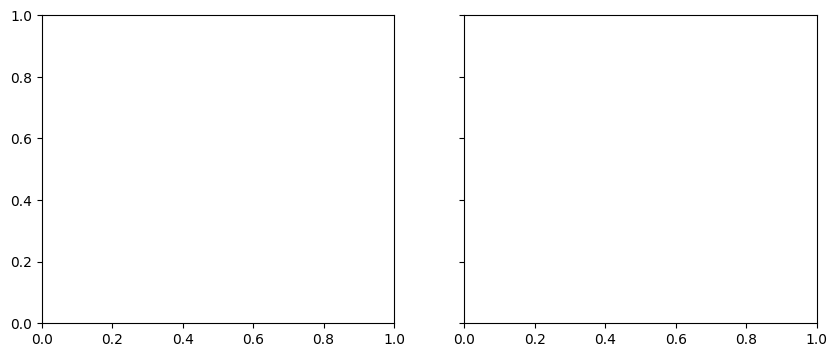

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

def plot_raw_vs_weighted_irf(
    df: pd.DataFrame,
    frequency: str = "daily",    # "daily" or "weekly"
    maxlags: int = 5,
    steps:   int = 5
):
    df = df.copy()
    # 1) ensure our date & price cols exist
    df['adjusted_close'] = df['adjusted_close'].astype(float)
    if frequency == "daily":
        df['day_date'] = pd.to_datetime(df['day_date'])
        time_col, ret_col = 'day_date', 'return_d'
        # compute daily return
        df[ret_col] = df['adjusted_close'].pct_change()
    else:
        df['week'] = pd.to_datetime(df['day_date']).dt.to_period('W').apply(lambda r: r.start_time)
        time_col, ret_col = 'week', 'return_w'
        # compute weekly return
        weekly = df.groupby('week')['adjusted_close'].last()
        df = df.merge(
            weekly.pct_change().rename(ret_col).reset_index(),
            on='week', how='left'
        )

    # drop any rows without a return
    df = df.dropna(subset=[ret_col])

    # 2) build a weighted version of TSS_av
    df["TSS_av_weighted"] = df["TSS_av"] * df["TRS_av"]

    # 3) select only the columns we need for the VAR
    cols = [time_col, "TSS_av", "TSS_av_weighted", ret_col]
    var_df = df[cols].dropna().set_index(time_col)

    # 4) stationarize any non‐stationary series
    def make_stationary(x):
        y = x.copy()
        for c in x.columns:
            if adfuller(x[c])[1] > 0.05:
                y[c] = x[c].diff()
        return y.dropna()
    df_s = make_stationary(var_df)

    # 5) fit VAR and pick optimal lag by AIC
    m   = VAR(df_s)
    lag = max(int(m.select_order(maxlags).aic), 1)
    res = m.fit(lag)
    print(f"{frequency.capitalize()} VAR → lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # 6) compute IRFs + standard errors
    irf    = res.irf(steps)
    impulses = ["TSS_av", "TSS_av_weighted"]

    # 7) plot 1×2 grid of IRFs with 95% CIs
    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    for ax, imp in zip(axes, impulses):
        i    = res.names.index(imp)
        j    = res.names.index(ret_col)
        pts  = irf.irfs[1:, j, i]                     # horizons 1…steps
        se   = irf.stderr(impulse=imp, response=ret_col, orth=False)
        low  = pts - 1.96*se
        high = pts + 1.96*se
        x    = np.arange(1, steps+1)

        ax.plot(x, pts, marker='o', label='IRF')
        ax.fill_between(x, low, high, alpha=0.3, label='±1.96·SE')
        ax.axhline(0, color='k', lw=0.7)
        ax.set_title(f"{imp} → {ret_col}")
        ax.set_xlabel("Horizon")
        if imp == "TSS_av":
            ax.set_ylabel("Response")
        ax.set_xticks(x)
        ax.grid(alpha=0.3)
        ax.legend()

    fig.suptitle(f"Impulse Responses ({frequency.capitalize()})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.show()

    # 8) optional: numeric forecast printout
    fc    = res.forecast(df_s.values[-lag:], steps=steps)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1,steps+1)])
    print("Forecast (next steps):")
    display(fc_df)


# ─── run it ─────────────────────────────────────────────────────────────────

# daily
plot_raw_vs_weighted_irf(merged_daily,  frequency="daily",  maxlags=5, steps=5)

# weekly
plot_raw_vs_weighted_irf(merged_weekly, frequency="weekly", maxlags=5, steps=5)


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR, SVAR
from statsmodels.tsa.stattools import adfuller

# --- 1) Prepare the same df with TSS_* and return_d as before ---
df = merged_daily.copy()

# ensure day_date is a column, not an index
df = df.reset_index(drop=True)             # drop any old index
df['day_date'] = pd.to_datetime(df['day_date'])

# now it’s unambiguous
df = df.sort_values('day_date')

df['return_d'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['return_d'])

# identify all five sentiment series
impulses = [c for c in df if c.startswith('TSS_')]

# build and stationarize the VAR sample
df_var = df[['day_date'] + impulses + ['return_d']].dropna().set_index('day_date')
def make_stationary(x):
    y = x.copy()
    for col in x.columns:
        if adfuller(x[col])[1] > 0.05:
            y[col] = x[col].diff()
    return y.dropna()
df_s = make_stationary(df_var)

# fit the reduced‐form VAR
model = VAR(df_s)
lag   = max(int(model.select_order(5).aic), 1)
res   = model.fit(lag)

# 2) Cholesky IRFs (just for reference)
irf_chol = res.irf(5)

# 3) Structural VAR: impose A matrix so that
#    return_d does NOT load contemporaneously on sentiment shocks.
#
#    A @ u_t = B @ ε_t,
#    with A lower‐triangular:
#        [ 1      0      0    ...   0 ]
#        [ γ21    1      0    ...   0 ]
#         ...
#
#    Here: we want that the *last* variable (return_d) 
#    is allowed to respond contemporaneously to each sentiment,
#    but sentiment cannot respond contemporaneously to return:
#
k = len(impulses) + 1
A = np.eye(k)
# rows = variables, cols = contemporaneous IVs
# we order vars = impulses + ['return_d']
# impose zeroes above the main diagonal:
for i in range(k):
    for j in range(i+1, k):
        A[i,j] = 0.0
# leave A[i,i] = 1, and allow A[last, 0:last] free:
# so sentiment shocks (rows 0..k-2) unaffected by return shock (col k-1)
# but return (row k-1) may load on sentiment (col < k-1), so A[k-1, j] ≠0 is allowed.

# fit SVAR
svar = SVAR(res, A=A, B=None, svar_type='A')
sres = svar.fit()

# structural IRFs
irf_struc = sres.irf(5)

# 4) plot side by side for each sentiment → return_d
horizons = np.arange(1, 6)
fig, axes = plt.subplots(2, len(impulses), figsize=(4*len(impulses), 6),
                         sharex=True, sharey=True)
for idx, imp in enumerate(impulses):
    # reduced‐form IRF
    y_chol = irf_chol.irfs[1:, -1, idx]      # response of return_d (last var) to shock idx
    ax = axes[0, idx]
    ax.plot(horizons, y_chol, 'o-', label='Cholesky')
    ax.axhline(0, color='k', lw=0.5)
    ax.set_title(f"{imp} → return_d\n(Reduced)")
    ax.set_xticks(horizons)

    # structural IRF
    y_str = irf_struc.irfs[1:, -1, idx]
    ax2 = axes[1, idx]
    ax2.plot(horizons, y_str, 'o-', color='C3', label='Structural')
    ax2.axhline(0, color='k', lw=0.5)
    ax2.set_title(f"{imp} → return_d\n(Structural)")
    ax2.set_xticks(horizons)

for row in axes:
    for ax in row:
        ax.grid(alpha=0.3)
axes[0,0].set_ylabel("IRF (Δ return)")
axes[1,0].set_ylabel("IRF (Δ return)")
fig.suptitle("Daily Impulse Responses: Cholesky vs Structural VAR", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: unrecognized data structures: <class 'statsmodels.tsa.vector_ar.var_model.VARResultsWrapper'> / <class 'NoneType'>